In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from quantstats.stats import sharpe
from utils.func import center

In [2]:
universe = master.baskets.get_index_historical_components('GSPC')
P = func.presence_matrix(universe).loc['2008':]

In [3]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
# P = pd.read_parquet('data/US/universe_table.pq')
income_statement = pd.read_parquet('data/US/income_statement.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()

In [4]:
metrics = (-balance_sheet['netDebt'].astype(float)/balance_sheet['cash'].astype(float))
netdebt = metrics.unstack().ffill()
netdebt = netdebt.rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
netdebt.index = pd.to_datetime(netdebt.index)
netdebt = netdebt.rolling(10).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
netdebt = netdebt.reindex_like(P).ffill()



C:\Users\marti\AppData\Local\Temp\ipykernel_23108\322947803.py:5: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  netdebt = netdebt.rolling(10).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)


C:\Users\marti\AppData\Local\Temp\ipykernel_23108\4222979186.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  SIGNAL = SIGNAL[P].groupby(GICS['gicgrp'],axis=1).apply(center)


Sharpe      1.3
Turnover    0.0
biais       1.0
dtype: float64

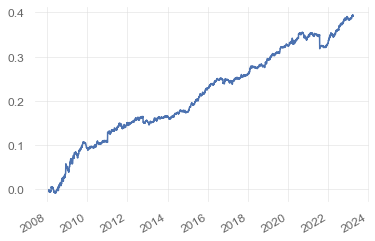

In [5]:
SIGNAL = netdebt.copy()
SIGNAL = SIGNAL[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
SIGNAL[SIGNAL.abs()<0.1] = None

SIGNAL = SIGNAL[P].groupby(GICS['gicgrp'],axis=1).apply(center)
SIGNAL= SIGNAL.div(SIGNAL.abs().sum(1),0)

pnl_net_debt = (SIGNAL.shift(1) *R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(pnl_net_debt)
turnover = SIGNAL.fillna(0).diff().abs().sum(1).mean()
pnl_net_debt.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl_net_debt.mean()*1e4}).round(1)